In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src.datasets import camvid
from src import evaluate
from src import plot
from src import predict
from src import predict_video
from src.tiramisu import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

Using TensorFlow backend.


In [2]:
# the location to save coarse training weights to
coarse_weights = 'models/Tiramisu56-CamVid11-coarse.h5'
# the location to save fine training weights to
fine_weights = 'models/Tiramisu56-CamVid11-fine.h5'

In [3]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the batch size during coarse training
coarse_batch = 3
# the size to crop images to for fine tune training
fine_crop = (352, 480)
# the batch size during fine training
fine_batch = 1

# Coarse Tuning

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.CamVid.load_mapping(),
    target_size=target_size,
    crop_size=coarse_crop,
    batch_size=coarse_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


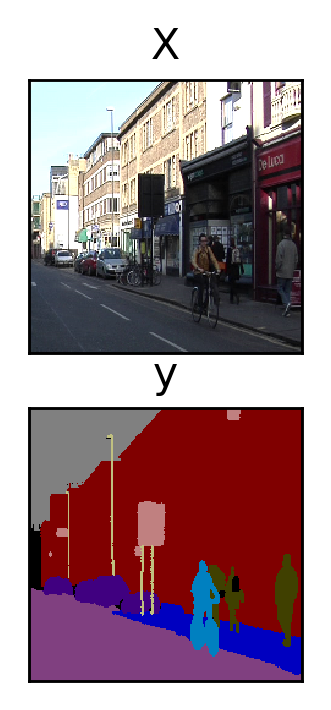

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = plot.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = tiramisu.tiramisu((*coarse_crop, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    growth_rate=12,
    layer_sizes=[4, 4, 4, 4, 4],
    bottleneck_size=4,
    learning_rate=1e-3,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 224, 224, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=100,
        mode='max',
    ),
    LearningRateScheduler(lambda _, lr: 0.995 * lr),
    ModelCheckpoint(coarse_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max',
    ),
    PlotMetrics(),
]

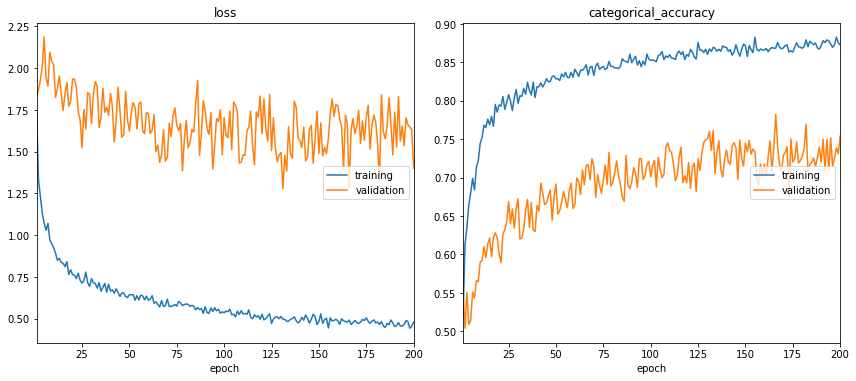

In [8]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / coarse_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=1,
)

In [9]:
history_to_results(history)

train       val
categorical_accuracy  0.872655  0.754032
loss                  0.478942  1.401032

## Test Metrics

In [10]:
model.load_weights(coarse_weights)

In [11]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map,
)
metrics.to_csv(coarse_weights + '.csv')
metrics

100%|██████████| 233/233 [00:42<00:00,  5.45step/s]


Value
Accuracy                 0.837711
Mean Per Class Accuracy  0.636297
Mean I/U                 0.465118
Bicyclist                0.145589
Building                 0.681242
Car                      0.590241
Column_Pole              0.198677
Fence                    0.215946
Pedestrian               0.239237
Road                     0.850235
Sidewalk                 0.552857
SignSymbol               0.150865
Sky                      0.875595
VegetationMisc           0.615812

In [12]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.837711 |
| Mean Per Class Accuracy | 0.636297 |
| Mean I/U                | 0.465118 |
| Bicyclist               | 0.145589 |
| Building                | 0.681242 |
| Car                     | 0.590241 |
| Column_Pole             | 0.198677 |
| Fence                   | 0.215946 |
| Pedestrian              | 0.239237 |
| Road                    | 0.850235 |
| Sidewalk                | 0.552857 |
| SignSymbol              | 0.150865 |
| Sky                     | 0.875595 |
| VegetationMisc          | 0.615812 |


## Qualitative Results

### Train

In [13]:
X, y, p = predict.predict(model, generators['train'], camvid11)

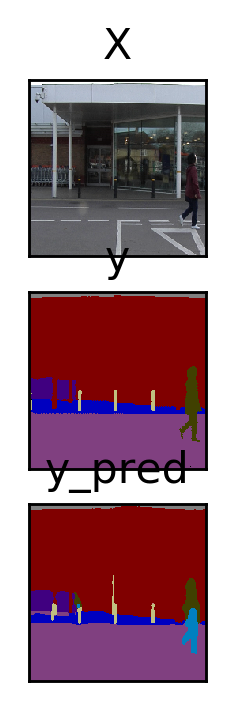

In [14]:
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

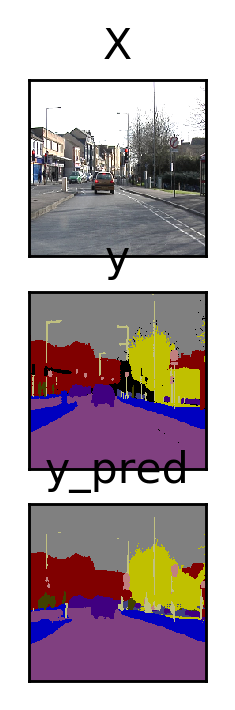

In [15]:
_ = plot.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

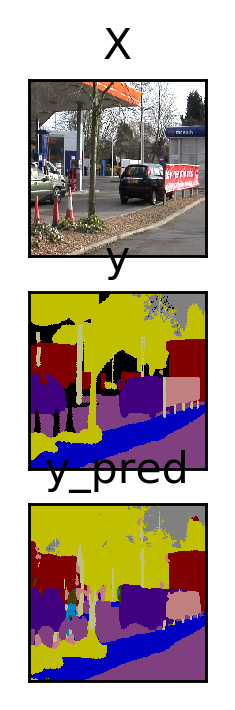

In [16]:
_ = plot.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

### Validation

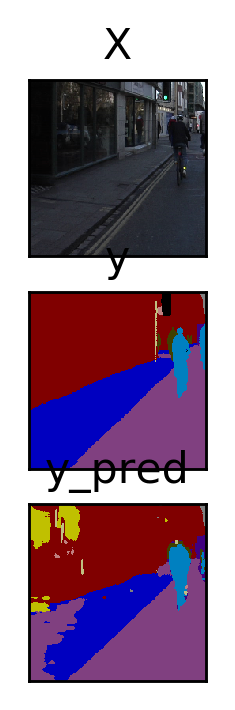

In [17]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

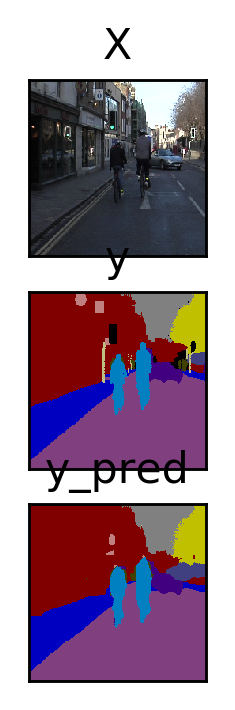

In [18]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

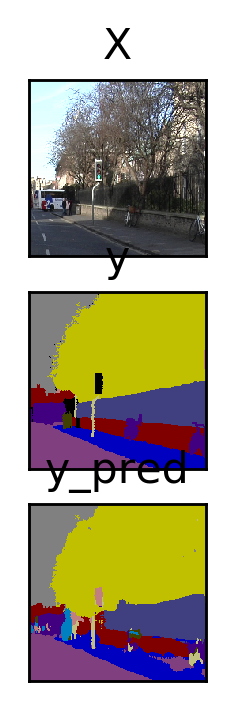

In [19]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

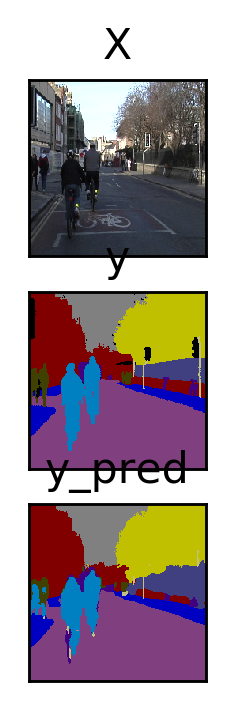

In [20]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

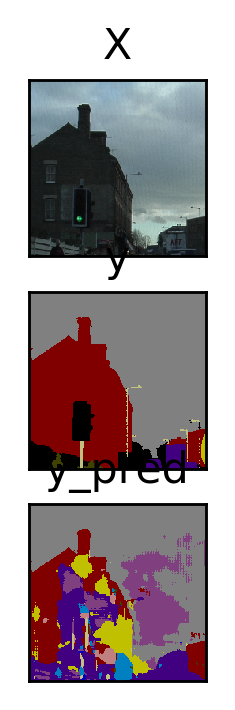

In [21]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

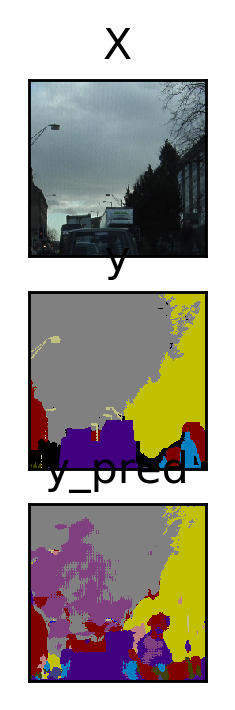

In [22]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

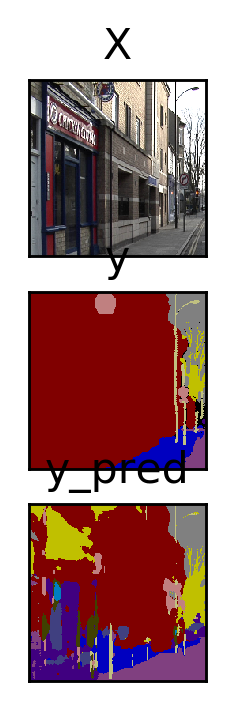

In [23]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

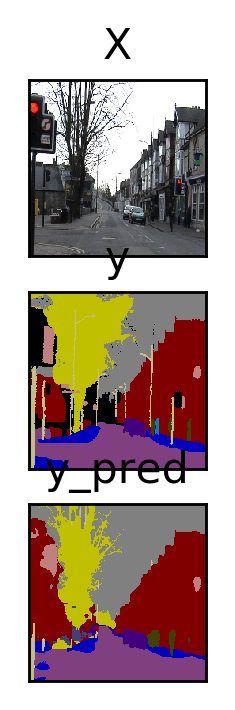

In [24]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

# Clear Session

remove the current model from memory.

In [25]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [26]:
camvid11 = camvid.CamVid(
    mapping=camvid.CamVid.load_mapping(),
    target_size=target_size,
    crop_size=fine_crop,
    batch_size=fine_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


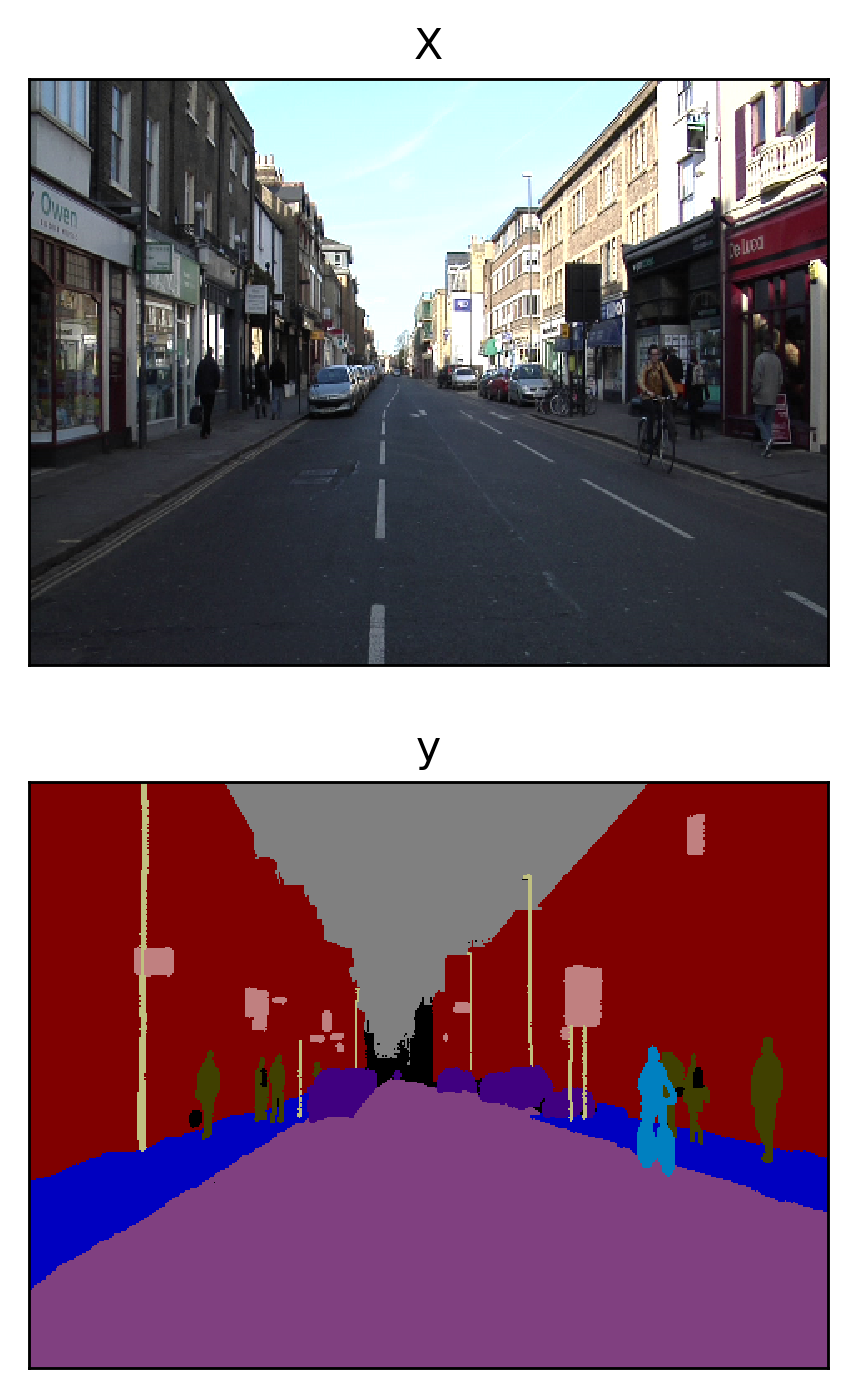

In [27]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = plot.plot(X=X[0], y=y[0], order=['X', 'y'])

In [28]:
# build the model for the image shape and number of labels
tune_model = tiramisu.tiramisu((*fine_crop, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    growth_rate=12,
    layer_sizes=[4, 4, 4, 4, 4],
    bottleneck_size=4,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights(coarse_weights)
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [29]:
callbacks = [
    EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=50,
        mode='max',
    ),
    ModelCheckpoint(fine_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max',
    ),
    PlotMetrics(),
]

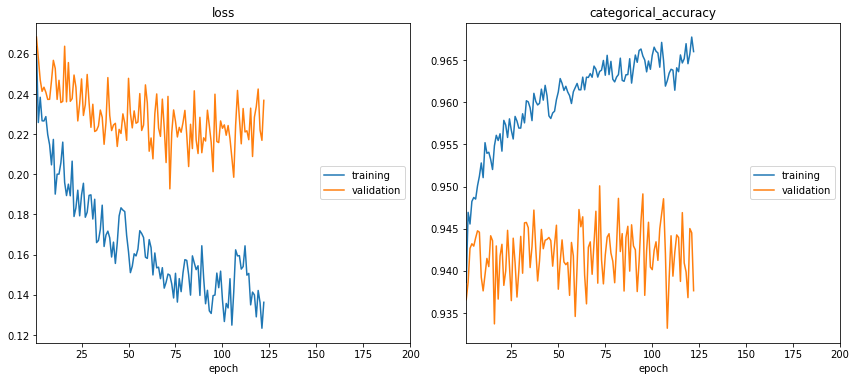

In [30]:
# fit the model with the data.
history = tune_model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / fine_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=1,
)

In [31]:
history_to_results(history)

train       val
categorical_accuracy  0.966037  0.937629
loss                  0.136267  0.236780

## Test Metrics

In [32]:
tune_model.load_weights(fine_weights)

In [33]:
metrics = evaluate.evaluate(tune_model, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map,
)
metrics.to_csv(fine_weights + '.csv')
metrics

100%|██████████| 233/233 [01:06<00:00,  3.51step/s]


Value
Accuracy                 0.893499
Mean Per Class Accuracy  0.729167
Mean I/U                 0.554183
Bicyclist                0.242725
Building                 0.756786
Car                      0.679571
Column_Pole              0.296699
Fence                    0.220566
Pedestrian               0.365200
Road                     0.908521
Sidewalk                 0.780023
SignSymbol               0.212098
Sky                      0.922870
VegetationMisc           0.710954

In [34]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.893499 |
| Mean Per Class Accuracy | 0.729167 |
| Mean I/U                | 0.554183 |
| Bicyclist               | 0.242725 |
| Building                | 0.756786 |
| Car                     | 0.679571 |
| Column_Pole             | 0.296699 |
| Fence                   | 0.220566 |
| Pedestrian              | 0.3652   |
| Road                    | 0.908521 |
| Sidewalk                | 0.780023 |
| SignSymbol              | 0.212098 |
| Sky                     | 0.92287  |
| VegetationMisc          | 0.710954 |


## Qualitative Results

### Train

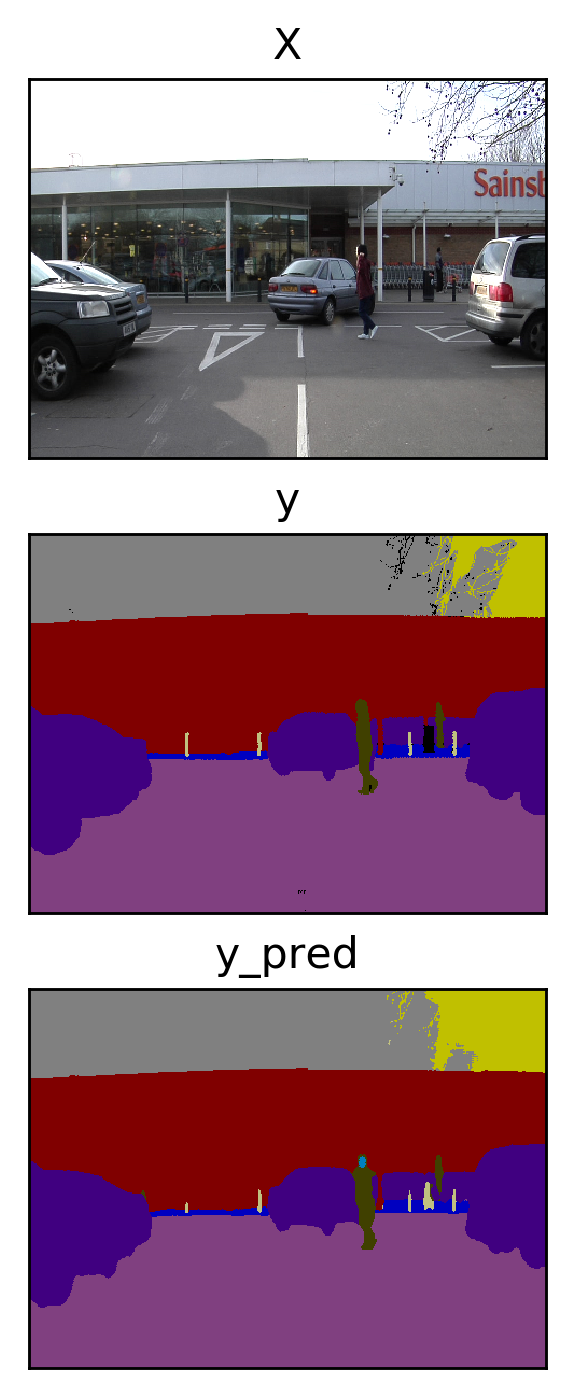

In [35]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

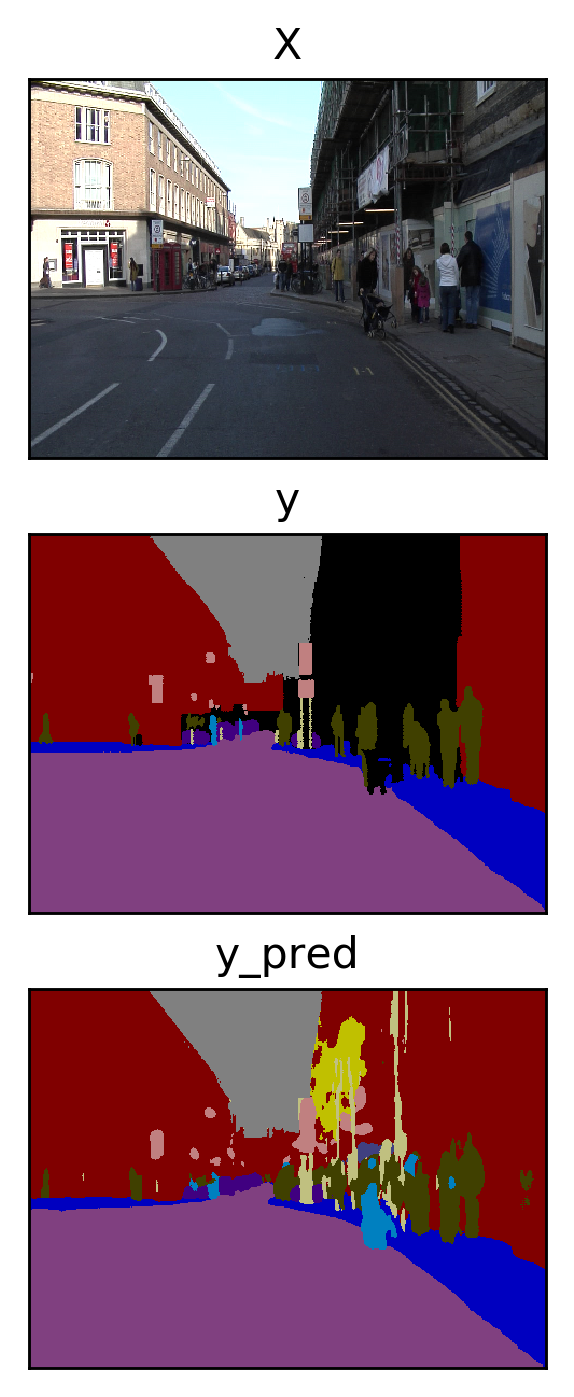

In [36]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

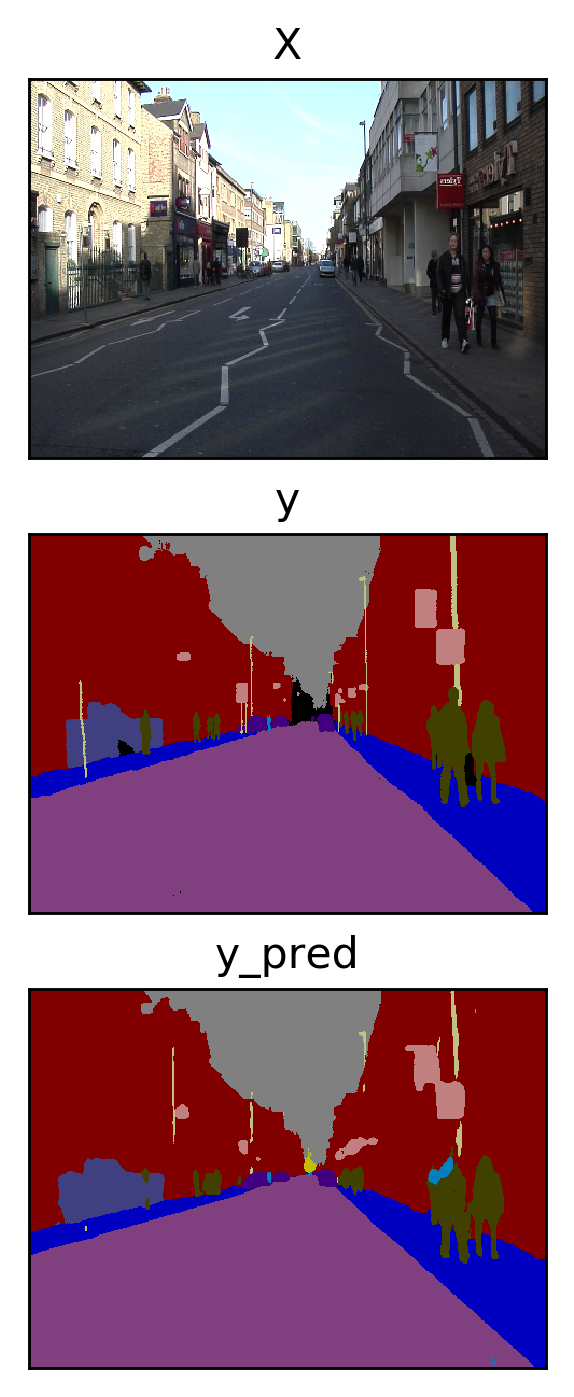

In [37]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

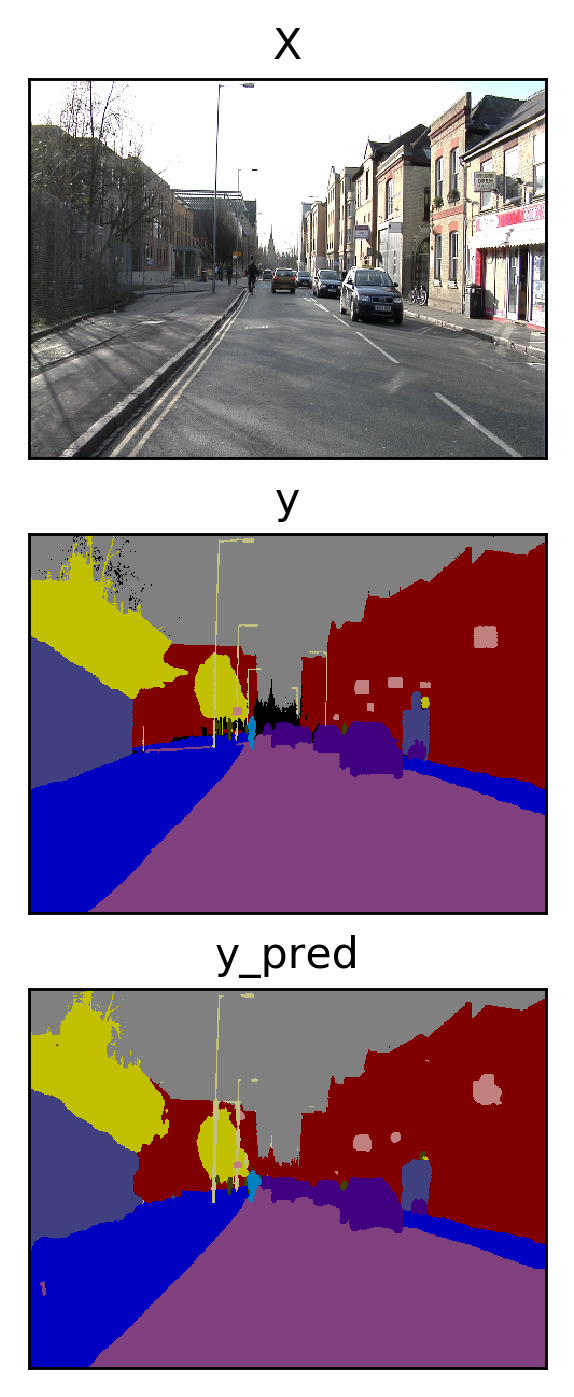

In [38]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Validation

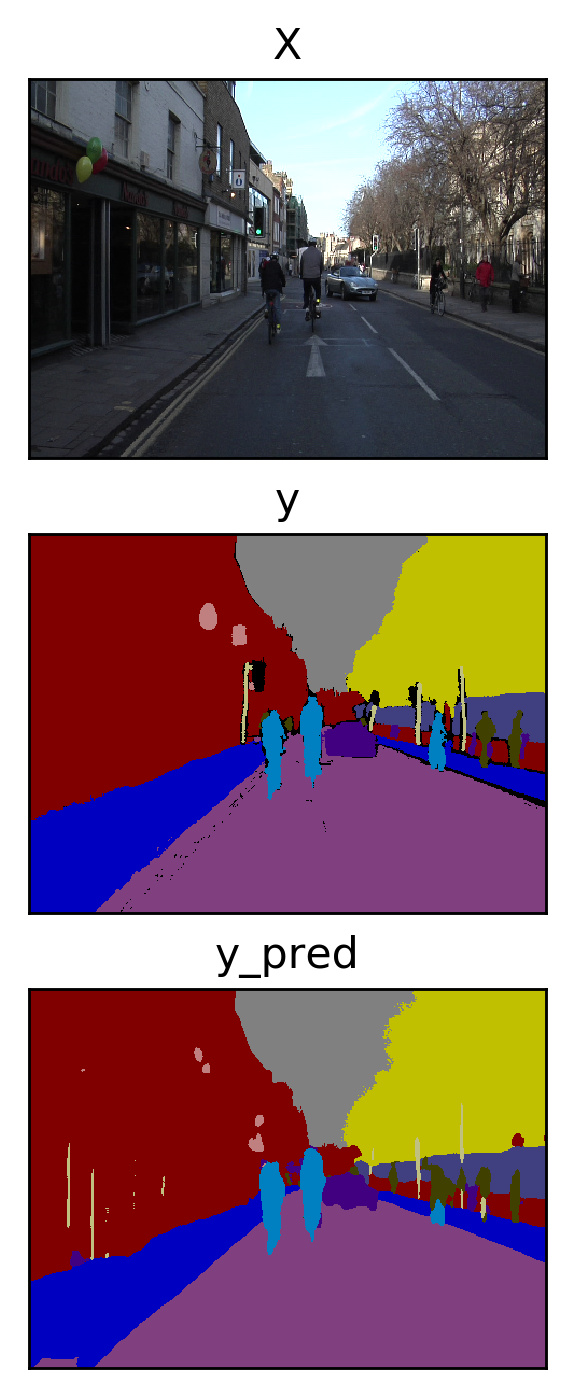

In [39]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

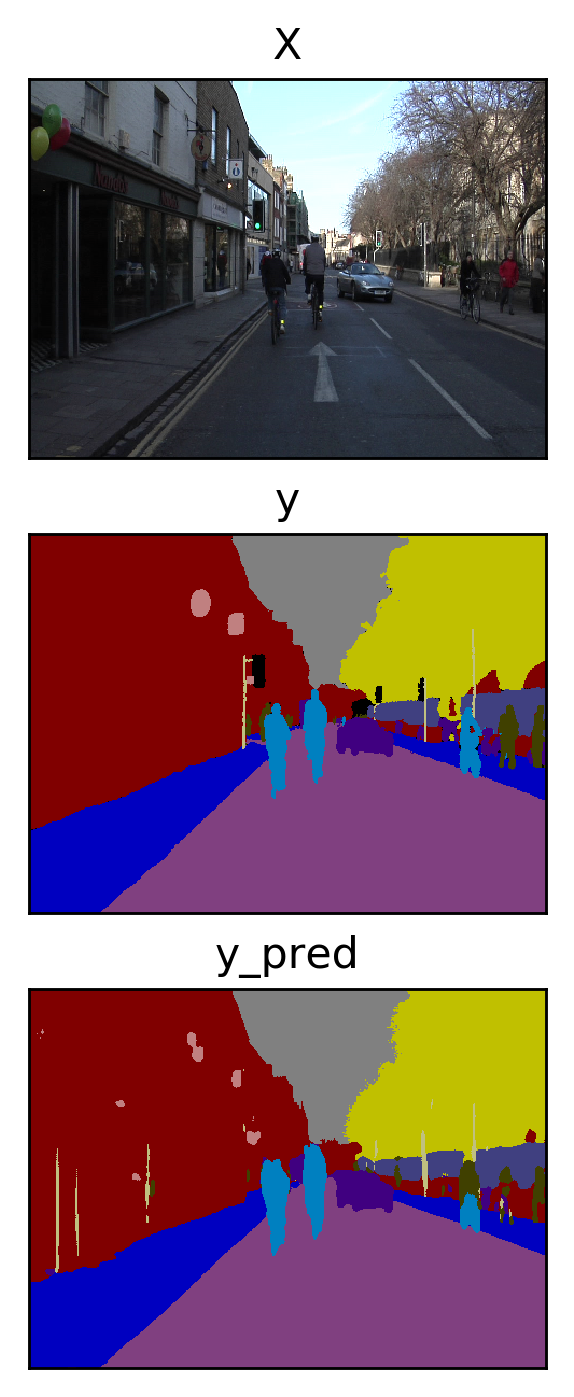

In [40]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

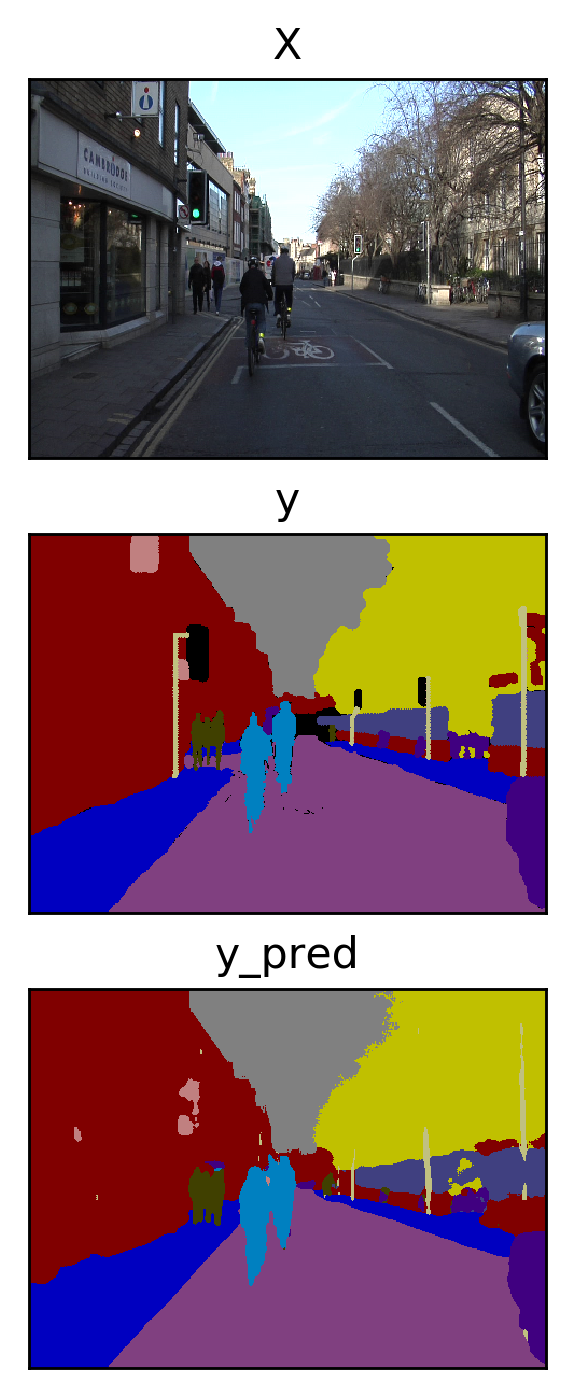

In [41]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

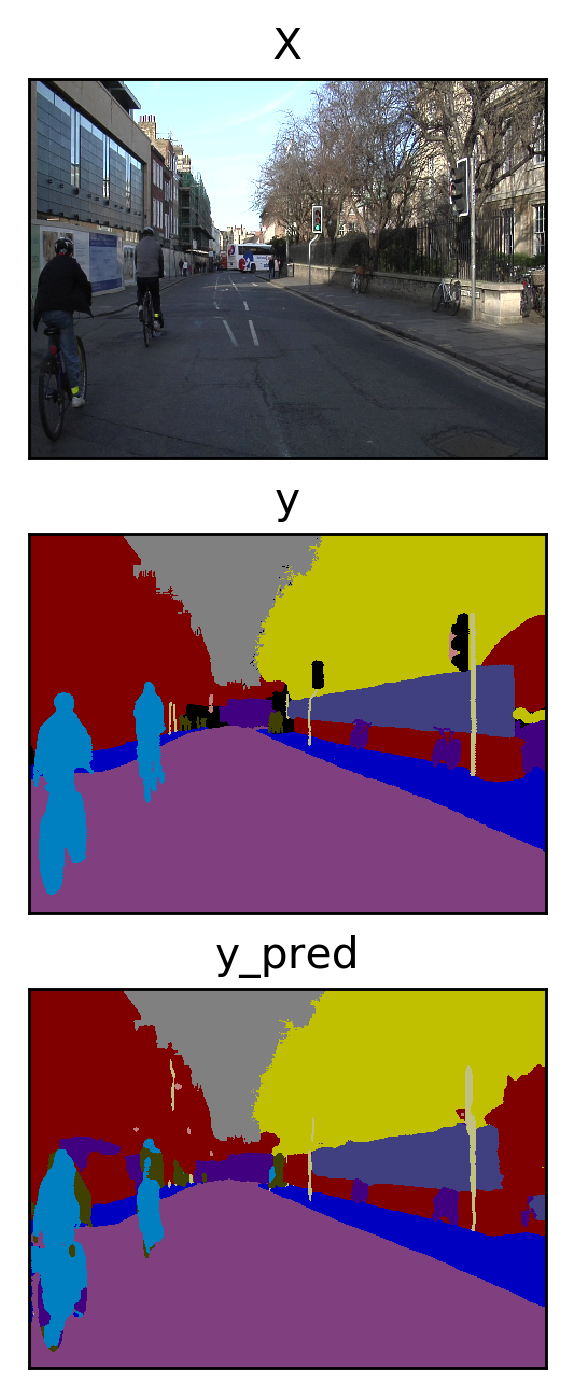

In [42]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

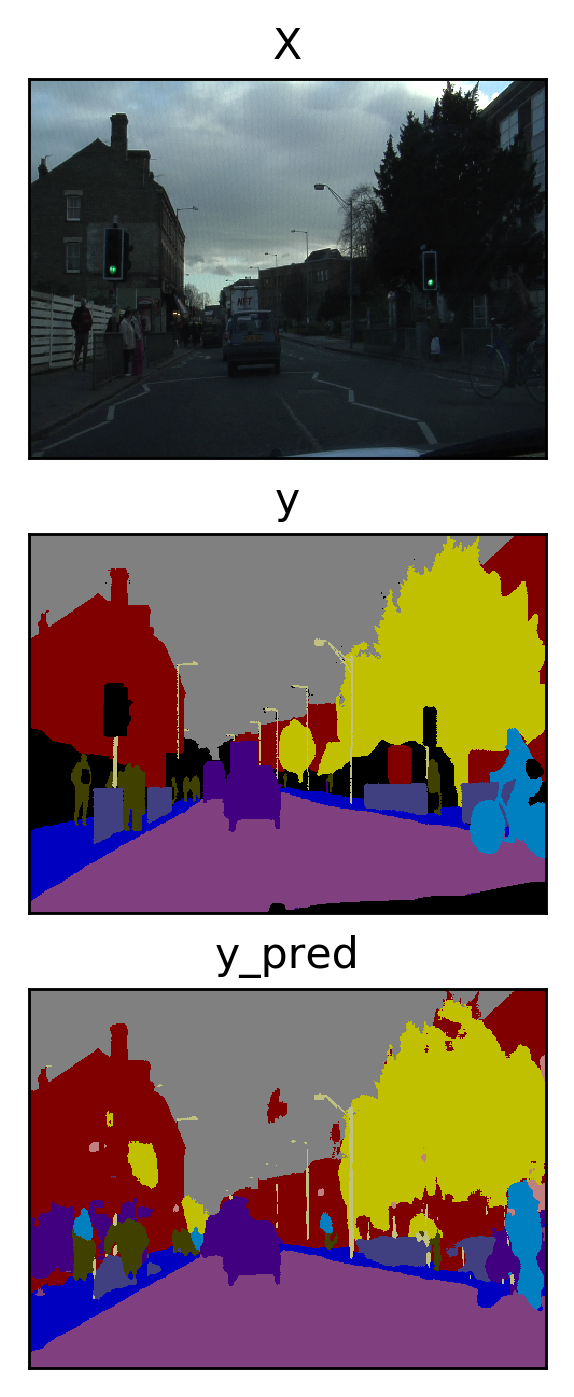

In [43]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/56/0.png', transparent=True, bbox_inches='tight')

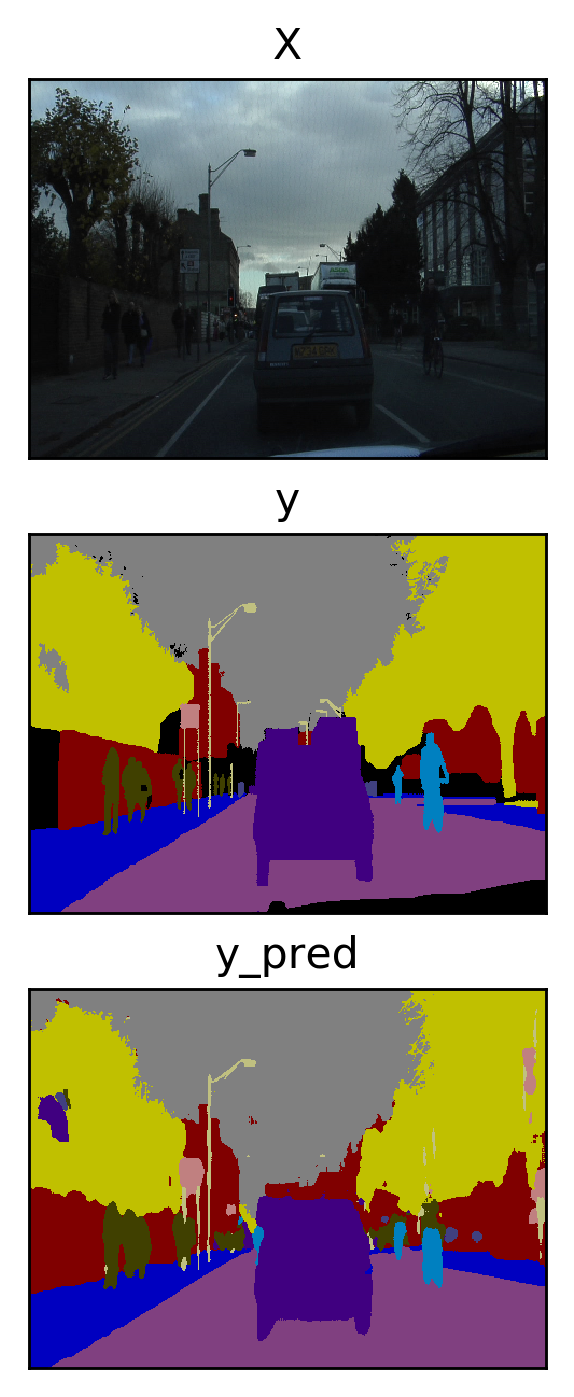

In [44]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/56/1.png', transparent=True, bbox_inches='tight')

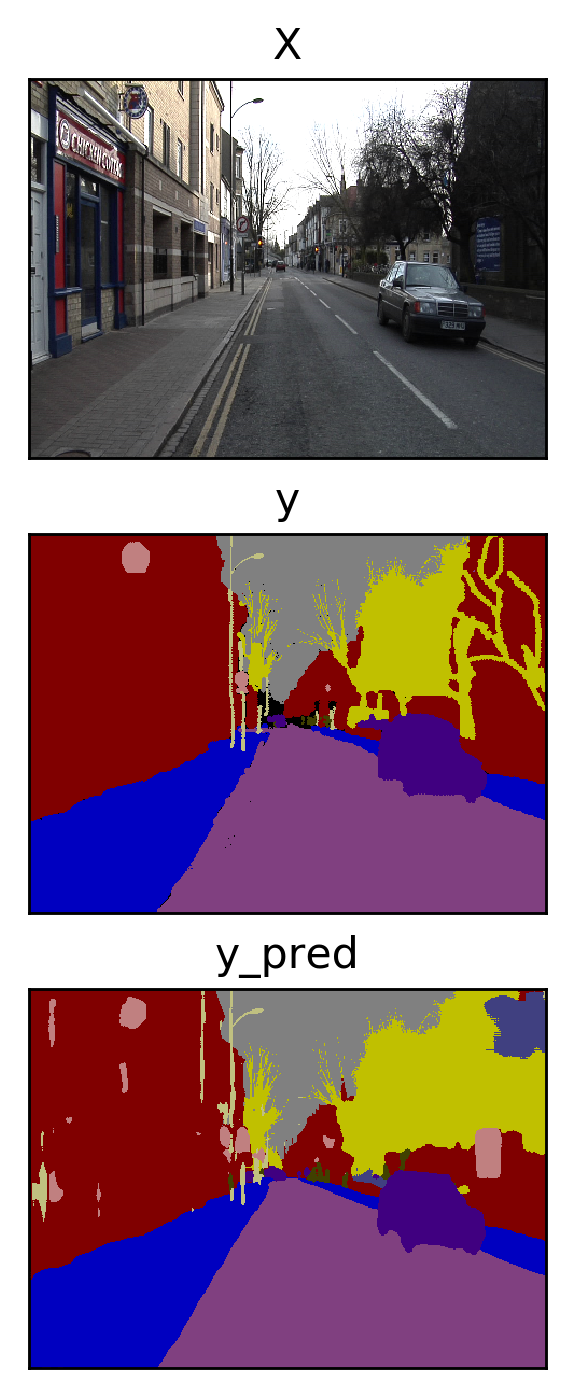

In [45]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/56/2.png', transparent=True, bbox_inches='tight')

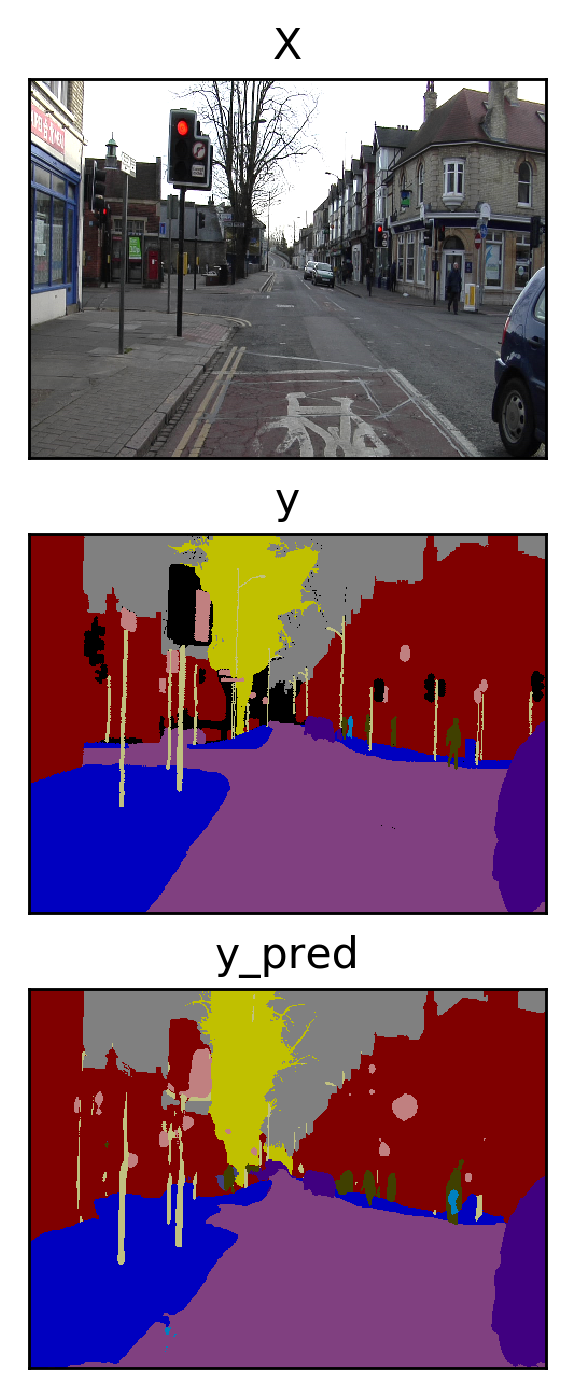

In [46]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/56/3.png', transparent=True, bbox_inches='tight')

# Video

In [47]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/tiramisu/56/{}'.format(video_file)

In [48]:
predict_video.predict_video(video_path, out_path, camvid11, tune_model, predict.predict)

100%|██████████| 6600/6600 [14:05<00:00,  7.80it/s]
